In [ ]:
### DATA PREPROCESSING
# data file: 20220502_resampled_dataset.csv
# Split and lowercase hashtags
# Create political stance columns
# Create text id column. This will let create bipartite network of users-tweets
# For each unique user get the latest attributes

In [2]:
import pandas as pd
import numpy as np
import os
import csv
import warnings
warnings.simplefilter(action='ignore')
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
data = pd.read_csv("20220502_resampled_dataset.csv",lineterminator='\n')
display(data.shape)
display(data.columns)

(161628, 13)

Index(['userid', 'username', 'location', 'language', 'tweetid',
       'tweetcreatedts', 'retweetcount', 'hashtags', 'text', 'usercreatedts',
       'following', 'followers', 'totaltweets'],
      dtype='object')

Preprocessing hashtags

In [35]:
tags = data['hashtags'].tolist()

TAGS=[]
for item in tags:
    TAGS+=item[1:-1].split('{')
TAGS2=[]
for item2 in TAGS:
    if item2!='':
        TAGS2+=[item2.split(': ')[1].split(',')[0][1:-1]]
tagdf=pd.DataFrame(pd.Series(TAGS2).value_counts())
tagdf['tag']=tagdf.index.tolist()
tagdf.columns=['counts','tag']
tagdf.index=range(len(tagdf))
tagdf[:20]

,counts,tag
0,53571,Ukraine
1,22759,Russia
2,17416,Putin
3,6135,StandWithUkraine
4,5327,UkraineRussiaWar
5,4778,StopPutin
6,4738,Russian
7,4730,UkraineRussianWar
8,4372,Kyiv
9,3909,NATO


Text(0.5, 0, 'Minimum number of hashtags')

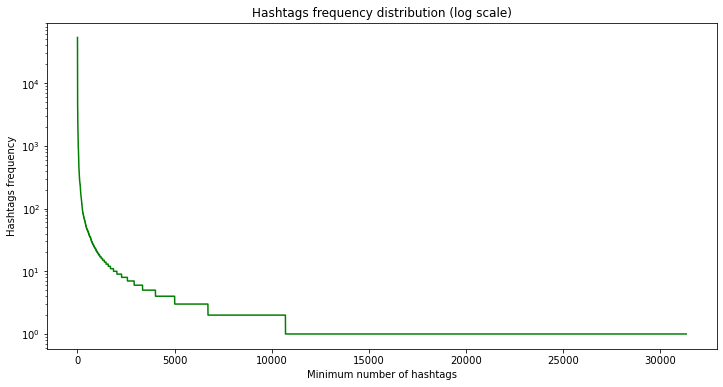

In [95]:
from math import log

y = tagdf["counts"]
x = range(len(tagdf))

plt.rcParams["figure.figsize"] = (12,6)
plt.plot(y, "g")
plt.yscale('log')
plt.title("Hashtags frequency distribution (log scale)")
plt.ylabel('Hashtags frequency')
plt.xlabel('Minimum number of hashtags')


In [158]:
# Getting hashtags which appear more than 80 times in the dataset
x = tagdf.index[tagdf['counts'] > 45][-1]
chosen_tags = tagdf.iloc[:x+1]
chosen_tags # 302 hashtags in total
chosen_tags

,counts,tag
0,53571,Ukraine
1,22759,Russia
2,17416,Putin
3,6135,StandWithUkraine
4,5327,UkraineRussiaWar
...,...,...
502,46,Oligarchs
503,46,геноцид
504,46,KIEV
505,46,FIFA


In [159]:
old_tags = pd.read_csv("hashtag_over30_tagged.csv")

pro_u = []
pro_r = []
neutral = []

for i in chosen_tags["tag"]:
    if i in old_tags["tag"].values:
        j = old_tags.loc[old_tags["tag"] == i]
        pro_u.append(j["Pro_U"].values[0])
        pro_r.append(False if j["Pro_R"].values[0] == "FALSE " else True)
        neutral.append(j["Neutral"].values[0])
    else:
        pro_u.append("X")
        pro_r.append("X")
        neutral.append("X")

chosen_tags.insert(loc=2, column="pro_u", value=pro_u)
chosen_tags.insert(loc=3, column="pro_r", value=pro_r)
chosen_tags.insert(loc=4, column="neutral", value=neutral)

chosen_tags.head(10)

,counts,tag,pro_u,pro_r,neutral
0,53571,Ukraine,False,False,True
1,22759,Russia,False,False,True
2,17416,Putin,False,False,True
3,6135,StandWithUkraine,True,False,False
4,5327,UkraineRussiaWar,False,False,True
5,4778,StopPutin,True,False,False
6,4738,Russian,False,False,True
7,4730,UkraineRussianWar,False,False,True
8,4372,Kyiv,False,False,True
9,3909,NATO,False,False,True


In [160]:
chosen_tags.to_string("for_labelling.txt")

In [11]:
# a function to split and clean "hashtags" column

def SplitTags(hashtags):
    TAGS=[]
    if hashtags != '[]':
        tags_split = hashtags[1:-1].split('{')
        for t in tags_split:
            if t!='':
                TAGS+=[t.split(': ')[1].split(',')[0][1:-1]]
        return TAGS
    else: return "NA"

def LowerTags(hashtags):
    TAGS=[]
    if hashtags != '[]':
        tags_split = hashtags[1:-1].split('{')
        for t in tags_split:
            if t!='':
                TAGS+=[t.split(': ')[1].split(',')[0][1:-1]]
    lower_TAGS = (map(lambda x: x.lower(), TAGS))
    TAGS = list(lower_TAGS)
    if len(TAGS)>0:
        return TAGS
    else: return "NA"

            
data['tags_splitted'] = data['hashtags'].apply(SplitTags)
data['tags_lower'] = data['hashtags'].apply(LowerTags)
data.head(2)

,userid,username,location,language,tweetid,tweetcreatedts,retweetcount,hashtags,text,usercreatedts,following,followers,totaltweets,tags_splitted,tags_lower
0,1497277564200517635,GulambiLamver,गुलाबी_स्तान,en,1497433817086234624,2022-02-26 04:50:17,0,"[{'text': 'Ukraine', 'indices': [40, 48]}, {'t...",Coz barking is our fundamental right..\n\n#Ukr...,2022-02-25 18:29:39.000000,4,0,2,"[Ukraine, UkraineUnderAttack, RussiaUkraineWar...","[ukraine, ukraineunderattack, russiaukrainewar..."
1,4832941924,Mari_Berbec,"Berlin, Germany",en,1497476520742309891,2022-02-26 07:39:58,0,"[{'text': 'putin', 'indices': [53, 59]}, {'tex...",@charlieweissr Socialism has nothing to do wit...,2016-01-21 13:57:12.000000,921,224,2848,"[putin, trump]","[putin, trump]"


Political stances

In [220]:
with open("labelled.txt", 'r', encoding='UTF-8') as infile:
    lines = infile.readlines()

    labelled_tags = pd.DataFrame(columns=lines[0].split())
    
    for line in lines[1:]:
        df_length = len(labelled_tags)
        labelled_tags.loc[df_length] = line.split()[1:]


In [221]:
labelled_tags["pro_u"] = labelled_tags["pro_u"].apply(lambda x: eval(x))
labelled_tags["pro_r"] = labelled_tags["pro_r"].apply(lambda x: eval(x))
labelled_tags["neutral"] = labelled_tags["neutral"].apply(lambda x: eval(x))
labelled_tags.head()

,counts,tag,pro_u,pro_r,neutral
0,53571,Ukraine,False,False,True
1,22759,Russia,False,False,True
2,17416,Putin,False,False,True
3,6135,StandWithUkraine,True,False,False
4,5327,UkraineRussiaWar,False,False,True


In [230]:
pro_russian_tags = labelled_tags["tag"][labelled_tags["pro_r"]==True]
print("Pro Russian:",len(pro_russian_tags), pro_russian_tags.to_list())
pro_ukrainian_tags = labelled_tags["tag"][labelled_tags["pro_u"]==True]
print()
print("Pro Ukrainian:",len(pro_ukrainian_tags), pro_ukrainian_tags.to_list())
neural_tags = labelled_tags["tag"][labelled_tags["neutral"]==True]
print()
print("Neutral:",len(neural_tags), neural_tags.to_list())

Pro Russian: 5 ['RussiaUkraineConflict', 'IStandWithPutin', 'OpRussia', 'UkraineConflict', 'istandwithrussia']

Pro Ukrainian: 108 ['StandWithUkraine', 'StopPutin', 'SafeAirliftUkraine', 'UkraineUnderAttack', 'StopRussia', 'StopPutinNOW', 'UkraineInvasion', 'SlavaUkraini', 'StopWar', 'StandWithUkraine️', 'UkraineUnderAttaсk', 'PutinIsaWarCriminal', 'PutinWarCriminal', 'NoWar', 'StopRussianAggression', 'PutinsWar', 'UkraineRussiaCrisis', 'PutinHitler', 'StopWarInUkraine', 'UkraineCrisis', 'PutinWarCrimes', 'russianinvasion', 'StopTheWar', 'RussiaInvadedUkraine', 'NoFlyZone', 'CloseTheSky', 'StandWithUkriane', 'WARINUKRAINE', 'Peace', 'ClosetheSkyoverUkraine', 'PrayForUkraine', 'RussiaUkraineCrisis', 'IStandWithUkraine', 'WarCrimes', 'ProtectUАSky', 'RussianInvasion', 'peace', 'NoFlyZoneOverUkraine', 'standwithukraine', 'HelpUkraine', 'SupportUkraine', 'ukrainewar', 'sanctions', 'stoprussia', 'нетвойне', 'RussianWarCrimes', 'FreeUkraine', 'SaveUkraine', 'WeStandWithUkraine', 'Refugees', 

In [82]:
#Create political stance columns

pro_R_tags = ["IStandWithPutin","istandwithrussia","ISupportRussia","ZelenskyWarCriminal","Zenlenskyisawarcriminal",\
              "NaziUkraine","UkraineNazis","nazisinukraine","WarCrimesOfUkraine","PutinIsRight","StopHatingRussians",\
              "NATOWarCriminal", "PatrioticRussia"]
pro_U_tags = ["Istandwithukraine","Putinisawarcriminal","PutinWarCriminal","StandWithUkraine", "HandsOffUkraine",\
              "kievfree","UkraineUnderAttack","StopRussia","StopPutin","RussiaInvadedUkriane","StopPutinsWar",\
              "StopRussianAggression","ukraineinvasion","russianinvasion","RussiaInvadedUkraine","PrayingForUkraine",\
              "RussiaOutOfUkraine","StandWithUkriane","RussiaInvadesUkraine","PutinHitler"]
# Create lambda functions to mark political orientation if related hashtags were found 

# change all tags to lowercase before matching to avoid spelling difference
# df['tags_lower'] = map(lambda x: x.lower(), data['tags_splitted']) # error with NA
lower_R = (map(lambda x: x.lower(), pro_R_tags))
pro_R_tags = list(lower_R)

lower_U = (map(lambda x: x.lower(), pro_U_tags))
pro_U_tags = list(lower_U)


pro_R_check = lambda taglist: bool(set(taglist) & set(pro_R_tags)) # return true if overlap of two sets not empty
pro_U_check = lambda taglist: bool(set(taglist) & set(pro_U_tags)) 

data['pro_Russian'] = data['tags_lower'].apply(pro_R_check)
data['pro_Ukraine'] = data['tags_lower'].apply(pro_U_check)

In [ ]:
# # import hashtag file 
# df_tags = pd.read_csv("hashtag_over30_tagged.csv")

# pro_R_tags = df_tags[df_tags["Pro_R"]=="TRUE"]['tag'].to_list()

# pd.crosstab(index=df_tags['Pro_R'], columns='count') # 5
# pd.crosstab(index=df_tags['Pro_U'], columns='count') #61
# pd.crosstab(index=df_tags['Neutral'], columns='count') #178

# df_tags.sample(5)

In [83]:
data.head(2)

,userid,username,textid,location,language,tweetid,tweetcreatedts,retweetcount,hashtags,text,usercreatedts,following,followers,totaltweets,tags_splitted,tags_lower,pro_Russian,pro_Ukraine
0,1497277564200517635,GulambiLamver,0,गुलाबी_स्तान,en,1497433817086234624,2022-02-26 04:50:17,0,"[{'text': 'Ukraine', 'indices': [40, 48]}, {'t...",Coz barking is our fundamental right..\n\n#Ukr...,2022-02-25 18:29:39,4,0,2,"[Ukraine, UkraineUnderAttack, RussiaUkraineWar...","[ukraine, ukraineunderattack, russiaukrainewar...",False,True
1,4832941924,Mari_Berbec,1,"Berlin, Germany",en,1497476520742309891,2022-02-26 07:39:58,0,"[{'text': 'putin', 'indices': [53, 59]}, {'tex...",@charlieweissr Socialism has nothing to do wit...,2016-01-21 13:57:12,921,224,2848,"[putin, trump]","[putin, trump]",False,False


In [ ]:
# code for nodetype variable
def Poli_Stance(Pro_R, Pro_U):
    if df1[Pro_R] == "True":
        return "R"
    elif df1[Pro_U] == "True":
        return "U"
    else:
        return "NA"
    
#nodelist["NodeType"] = Poli_Stance(df1["pro_Russian"],df1["pro_Ukraine"])

# Determine a user type by it's hashtags: pro-russian / pro-ukrainian / unknown
nodesBefore['NodeType'] = np.where(
     nodesBefore['pro_Russian'] & nodesBefore['pro_Ukraine'], 'Both',
     np.where(
         nodesBefore['pro_Russian'],  'pro_Russian',
     np.where(
        nodesBefore['pro_Ukraine'], 'pro_Ukraine', 'Unknown'
     )))

nodesAfter['NodeType'] = np.where(
    nodesAfter['pro_Russian'] & nodesAfter['pro_Ukraine'], 'Both',
    np.where(
    nodesAfter['pro_Russian'], 'pro_Russian', 
    np.where(
        nodesAfter['pro_Ukraine'], 'pro_Ukraine', 'Unknown'
    )))

In [ ]:
# overlap1

projected_w_user_edges_2 = pd.read_csv("projected_w_user_edgelist_2.csv")
graph2_nodes = set(projected_w_user_edges_2["Target"])
nodes2 = set(nodesAfter["userid"].apply(lambda x: int(x)))
overlap2 = list(graph2_nodes & nodes2)
overlap2

Text id

In [33]:
print("Number of tweets:",len(data))
print("Number of unique texts:",data["text"].nunique())

retweets = data["text"].duplicated()
print("Number of retweets:", len(retweets[retweets == True]))

Number of tweets: 161628
Number of unique texts: 105158
Number of retweets: 56470


In [55]:
# Dictionary for text id 
unique_texts = data["text"].unique()
unique_hash = {text: i[0] for i, text in np.ndenumerate(unique_texts)}
print("Number of unique hashes:", len(unique_hash))
unique_keys = unique_hash.keys() #texts
unique_values = unique_hash.values() #indexes

# get text by id
list(unique_hash.keys())[list(unique_hash.values()).index(105157)]

Number of unique hashes: 105158


'JOE BIDEN SAYS HOW DO WE GET TO A PLACE WHERE #PUTIN DECIDES TO INVADE #RUSSIA 🤣🤣🤣😭😭😂😂\nPEOPLE VOTED FOR THIS GUY 🤣🤣🤣\nhttps://t.co/b3sl8XjbWK'

In [59]:
data.insert(loc=2, column="textid", value=[unique_hash[x] for x in data["text"]])

In [61]:
data[data["textid"] == 60]

,userid,username,textid,location,language,tweetid,tweetcreatedts,retweetcount,hashtags,text,usercreatedts,following,followers,totaltweets
60,1244706255970668544,AntraSharma1705,60,kurtis town,en,1497210440216162308,2022-02-25 14:02:40,958,"[{'text': 'PutinIsaWarCriminal', 'indices': [4...",Putin needs to be taken down!\n#PutinIsaWarCri...,2020-03-30 19:21:21.000000,1059,415,382
11253,292061074,sylvain_pharand,60,"St-Bruno, Qc, Canada",en,1497053686182338571,2022-02-25 03:39:47,526,"[{'text': 'PutinIsaWarCriminal', 'indices': [4...",Putin needs to be taken down!\n#PutinIsaWarCri...,2011-05-03 01:37:20.000000,1053,508,61381
18787,558956156,SimonVelocity,60,UK - EMEA - APAC - Americas,en,1497022987698065413,2022-02-25 01:37:48,316,"[{'text': 'PutinIsaWarCriminal', 'indices': [4...",Putin needs to be taken down!\n#PutinIsaWarCri...,2012-04-20 21:30:18.000000,4985,2289,25410


Systemize user attributes || NOT FINISHED

In [76]:
data['usercreatedts'] = pd.to_datetime(data['usercreatedts'], errors='coerce')
data.head(1)

,userid,username,textid,location,language,tweetid,tweetcreatedts,retweetcount,hashtags,text,usercreatedts,following,followers,totaltweets
0,1497277564200517635,GulambiLamver,0,गुलाबी_स्तान,en,1497433817086234624,2022-02-26 04:50:17,0,"[{'text': 'Ukraine', 'indices': [40, 48]}, {'t...",Coz barking is our fundamental right..\n\n#Ukr...,2022-02-25 18:29:39,4,0,2


In [ ]:
#cannot change
static_att = ["userid", "usercreatedts"]
# possible to change
change_att = ["username", "location", "language", "following", "followers"]
# definitely change
change_att = ["totaltweets"]

In [79]:
same_users = data["userid"].duplicated()
print("Number of unique users:",len(same_users[same_users == True]))

same_users1 = data["username"].value_counts()
same_users1.head()

Number of unique users: 31020
Number of unique users: 30896


Fidget02           54
autotechnoparts    48
TeamShakeri        48
global_manu        44
ihavemoredreams    43
Name: username, dtype: int64

In [84]:
### SAVE DATA FRAME

# easy format for saving and loading data frames
data.to_pickle("preprocessed_data.pkl")